In [1]:
import pandas as pd
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
import matplotlib.pyplot as plt
import numpy as np

# standard AutoRegression
from statsmodels.tsa.ar_model import AutoReg

#AR and MA model
from statsmodels.tsa.arima_model import ARMA

#AR I MA model
from statsmodels.tsa.arima_model import ARIMA

#S AR I MA X model, which one to use?
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import SARIMAX

#auto AR I MA
import pmdarima as pm

In [2]:
df_daily = pd.read_pickle("data_clean_daily.pkl")

In [3]:
df_arima = pd.DataFrame()
df_arima['id'] = df_daily['id'].copy()
df_arima['date'] = df_daily['time'].copy()
df_arima['mood_score'] = list(df_daily['mood']['mean'].copy())
len(df_arima)

1302

In [4]:
df_arima = df_arima[~df_arima['mood_score'].isna()]
df_arima

id       date  mood_score
0     AS14.01 2014-03-21        6.20
1     AS14.01 2014-03-22        6.40
2     AS14.01 2014-03-23        6.80
3     AS14.01 2014-03-24        6.00
4     AS14.01 2014-03-25        6.75
...       ...        ...         ...
1297  AS14.33 2014-05-27        6.20
1298  AS14.33 2014-05-28        8.20
1299  AS14.33 2014-05-29        7.00
1300  AS14.33 2014-05-30        6.80
1301  AS14.33 2014-05-31        7.00

[1296 rows x 3 columns]

In [5]:
df_user1 = df_arima[df_arima['id']=='AS14.01']

In [6]:
def plot_user(df, title='Mood'):
    plt.figure(figsize=(16,6), dpi=100)
    plt.plot(df['date'], df['mood_score'], color='tab:red')
    plt.gca().set(title=title, xlabel='Date', ylabel='Mood score')
    plt.show()

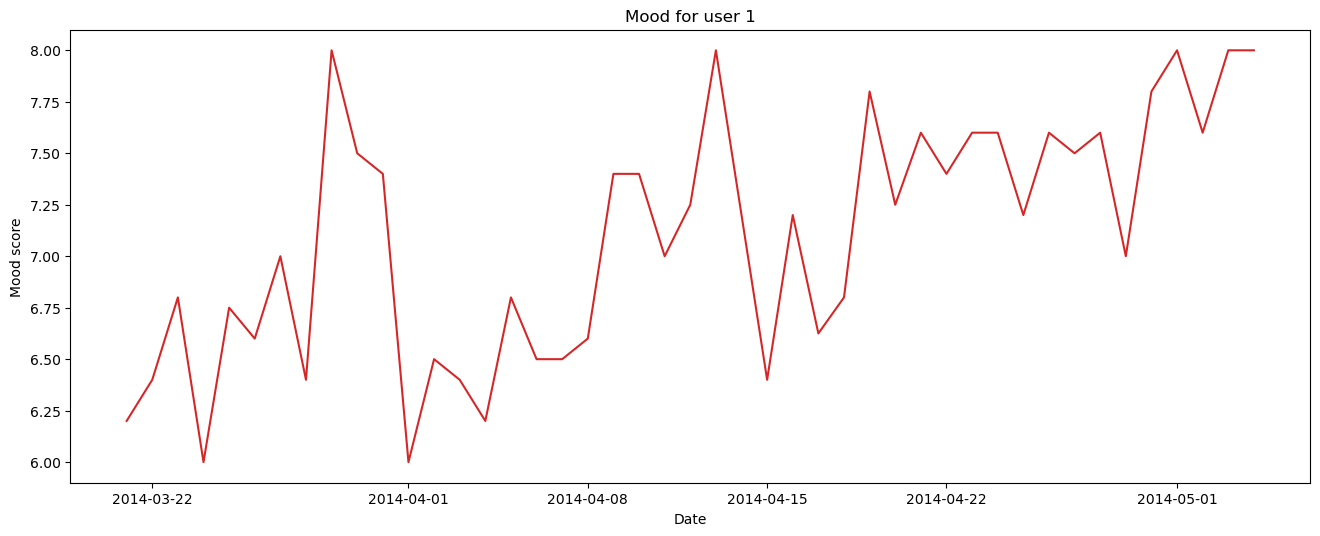

In [7]:
plot_user(df_user1, 'Mood for user 1')

In [8]:
def ADF_test(df):    
    df.set_index('date')

    # Augmented Dickey Fuller test: 
    # p-value < 0.05? --> time-series is stationary
    # p-value > 0.05? --> time-series is non-stationary
    result = adfuller(df['mood_score'])
    print('Augmented Dickey Fuller test')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print()

In [9]:
ADF_test(df_user1)

Augmented Dickey Fuller test
ADF Statistic: -3.677575
p-value: 0.004440



In [10]:
def plot_diff(df):
    plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
    
    # Original Series
    fig, axes = plt.subplots(3, 2, sharex=True)
    axes[0, 0].plot(df['mood_score']); axes[0, 0].set_title('Original Series')
    plot_acf(df['mood_score'], ax=axes[0, 1], lags = len(df['mood_score'])-1)
                
    # 1st Differencing
    axes[1, 0].plot(df['mood_score'].diff()); axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df['mood_score'].diff().dropna(), ax = axes[1, 1], lags= len(df['mood_score'])-2)
                
    # 2nd Differencing
    axes[2, 0].plot(df['mood_score'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df['mood_score'].diff().diff().dropna(), ax=axes[2, 1], lags= len(df['mood_score'])-3)

    plt.show()

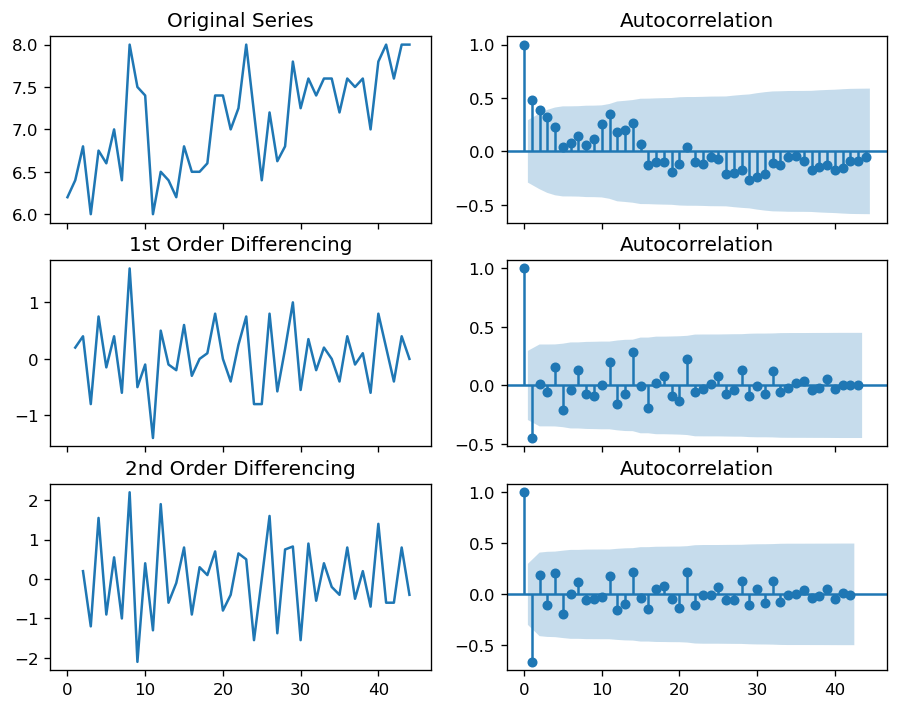

In [11]:
plot_diff(df_user1)

In [12]:
def stat_tests(df):
    ## Adf Test
    print("ADF: " +str(ndiffs(df['mood_score'], test='adf')) )
    # KPSS test
    print("KPSS: " + str( ndiffs(df['mood_score'], test='kpss')) )
    # PP test:
    print("PP: " + str( ndiffs(df['mood_score'], test='pp')) )

In [13]:
stat_tests(df_user1)

ADF: 1
KPSS: 1
PP: 0


C:\Users\doist\anaconda3\envs\Python37\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


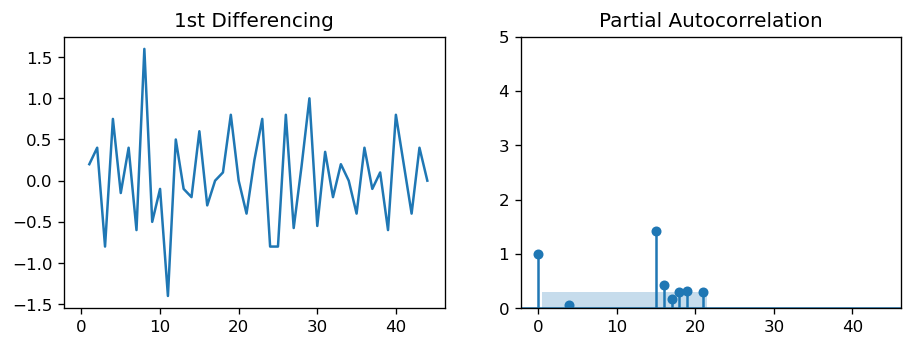

In [14]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_user1['mood_score'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_user1['mood_score'].diff().dropna(), ax=axes[1], lags=(len(df_user1['mood_score'])/2)-1)

plt.show()

### AR model:

In [15]:
train = df_user1['mood_score'][0:int(0.7*len(df_user1))]
test = df_user1['mood_score'][int(0.7)*len(df_user1):]

In [30]:
lags = 2

# fit model
model = AutoReg(train, lags=lags)
model_fit = model.fit()

# make prediction
model_prediction = model_fit.predict(start=lags, end=len(train)-1)
forecast = model_fit.predict(start=len(train), end=len(test)-1)

completeModel = model_fit.predict(start=lags, end=len(test)-1)
completeModel

C:\Users\doist\anaconda3\envs\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


2     6.736044
3     6.850721
4     6.690927
5     6.803780
6     6.832509
7     6.916754
8     6.805603
9     7.142580
10    7.160090
11    7.092294
12    6.743096
13    6.742976
14    6.762129
15    6.704791
16    6.833331
17    6.812535
18    6.786451
19    6.810772
20    7.014040
21    7.083599
22    6.986313
23    7.012337
24    7.216486
25    7.087125
26    6.822993
27    6.948007
28    6.877717
29    6.870284
30    7.128716
31    7.081896
32    6.993189
33    6.956997
34    6.940482
35    6.933318
36    6.930140
37    6.928744
38    6.928128
39    6.927857
40    6.927738
41    6.927685
42    6.927662
43    6.927651
44    6.927647
dtype: float64

In [31]:
#make dataframe of actual and predicted data
def putInDF(actualdata, predicted):
    df = pd.DataFrame(index=np.arange(actualdata.index[0],actualdata.index[-1]+1), columns=['Actual','Predicted'])
    df['Actual'] = np.array(actualdata)
    df['Predicted'] = np.array(predicted)
    return df

In [32]:
actualdata = df_user1[lags:len(train)+len(test)]['mood_score']
AR_model_forecast = putInDF(actualdata, completeModel)
AR_model_forecast

Actual  Predicted
2    6.800   6.736044
3    6.000   6.850721
4    6.750   6.690927
5    6.600   6.803780
6    7.000   6.832509
7    6.400   6.916754
8    8.000   6.805603
9    7.500   7.142580
10   7.400   7.160090
11   6.000   7.092294
12   6.500   6.743096
13   6.400   6.742976
14   6.200   6.762129
15   6.800   6.704791
16   6.500   6.833331
17   6.500   6.812535
18   6.600   6.786451
19   7.400   6.810772
20   7.400   7.014040
21   7.000   7.083599
22   7.250   6.986313
23   8.000   7.012337
24   7.200   7.216486
25   6.400   7.087125
26   7.200   6.822993
27   6.625   6.948007
28   6.800   6.877717
29   7.800   6.870284
30   7.250   7.128716
31   7.600   7.081896
32   7.400   6.993189
33   7.600   6.956997
34   7.600   6.940482
35   7.200   6.933318
36   7.600   6.930140
37   7.500   6.928744
38   7.600   6.928128
39   7.000   6.927857
40   7.800   6.927738
41   8.000   6.927685
42   7.600   6.927662
43   8.000   6.927651
44   8.000   6.927647

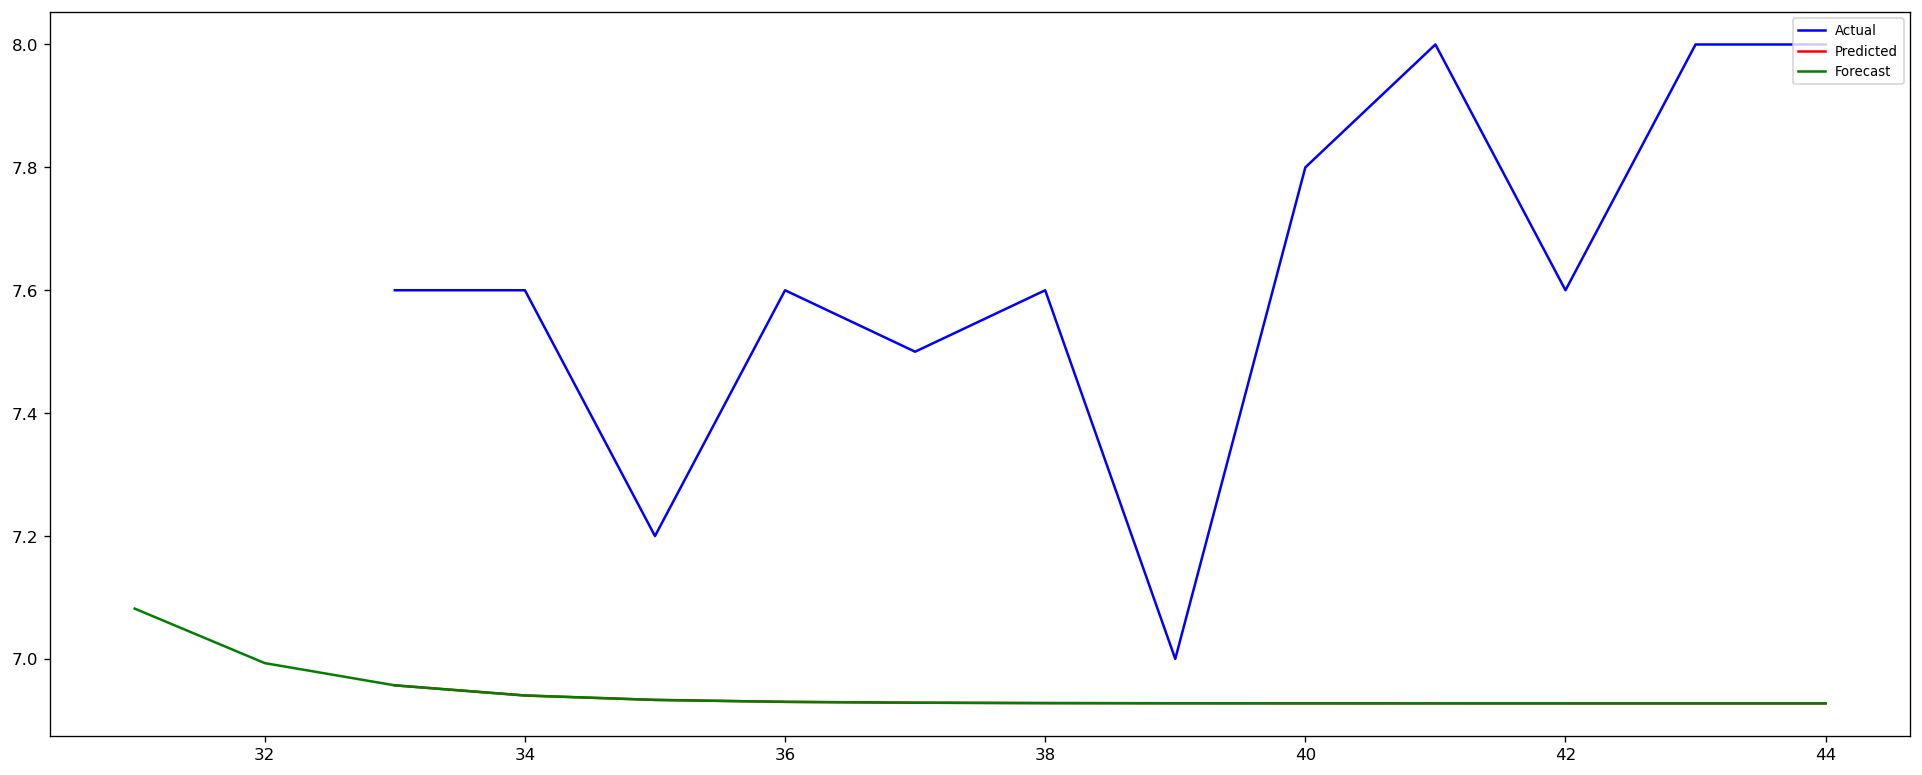

In [33]:
AR_model_forecast[len(train):]['Actual'].plot(figsize=(20,8), legend=True, color='blue')
AR_model_forecast[len(train):]['Predicted'].plot(figsize=(20,8), legend=True, color='red')
plt.plot(forecast, label='Forecast', color='green')
plt.legend(loc='upper right', fontsize=8)
plt.show()

<AxesSubplot:>

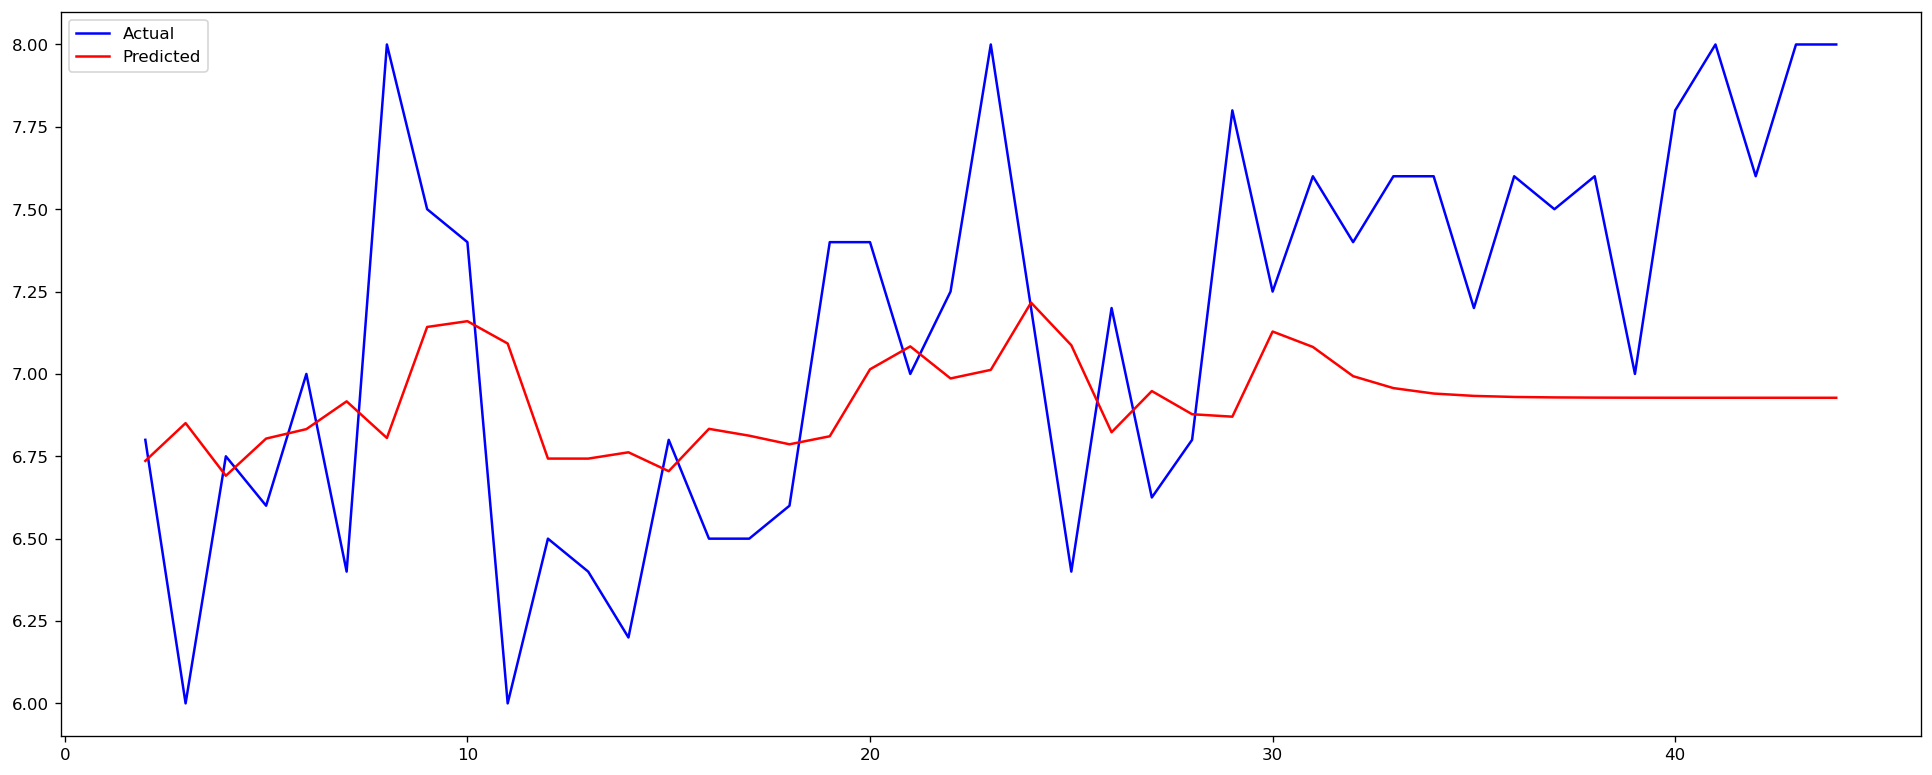

In [34]:
AR_model_forecast['Actual'].plot(figsize=(20,8), legend=True, color='blue')
AR_model_forecast['Predicted'].plot(figsize=(20,8), legend=True, color='red')